In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import jax
import jax.numpy as jnp
import itertools

from numpy.polynomial.legendre import legval, legder, leggauss
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.optimize import minimize
from scipy import interpolate
from keo import Molecule, com
from typing import List, Callable

In [2]:
#Define interpolater for surfaces
def interpolate(filename, index_pes):
    #index for the pes of interest, 0 = first, 1 = second, etc...
    pes = np.loadtxt(filename)
    R_pre = pes[:, 0]
    r_pre = pes[:, 1]
    gamma_pre = pes[:, 2] * np.pi/180.0# np.cos()
    sorted_index = np.lexsort((R_pre, r_pre, gamma_pre))
    pes = pes[sorted_index,:]
    #pes[:, 2] -= min_pes
    bohr_aa = 1/1.8897261246257702
    pes_values = pes[:, index_pes+3]
    index = sorted_index[np.argmin(pes_values)]
    
    R = np.unique(R_pre)*bohr_aa
    r = np.unique(r_pre)*bohr_aa
    gamma = np.unique(gamma_pre)

    pes_values = pes_values.reshape((len(gamma), len(r), len(R)))
    pes = RGI((gamma, r, R), pes_values, method='cubic', bounds_error=False, fill_value=None) #fill_value=None - extrapolate
    min_max_q = ([np.min(gamma),np.max(gamma)],[np.min(r),np.max(r)],[np.min(R),np.max(R)])
    q_eq = [gamma_pre[index],r_pre[index]*bohr_aa,R_pre[index]*bohr_aa]
    print('min on discrete PES:',np.min(pes_values),'q_eq:',q_eq)
    return pes,min_max_q, q_eq
    

In [4]:
#Load surfaces
name_X = "potential_data/ocs-X-state-pes_1_0.dat"
name_S = "potential_data/ocs-singlet-ap.dat" #'ocs-triplet-ap.dat' 

pes_X, min_max_q_X, q_eq = interpolate(name_X, 0)
minimize_info_X = minimize(pes_X, q_eq, args=(), method=None, jac=None, hess=None,
                 hessp=None, bounds=([0.0,np.pi],[min_max_q_X[1][0],min_max_q_X[1][1]],[min_max_q_X[2][0],min_max_q_X[2][1]]))
q_min_X = minimize_info_X.x
print('Mininum found:',minimize_info_X.success)
print('min on interpolated PES:',pes_X(q_min_X),'q_eq:',q_min_X)

index_S = 1 #Pick singles surface
pes_S, min_max_q_S, q_eq = interpolate(name_S, index_S)
minimize_info_S = minimize(pes_S, q_eq, args=(), method=None, jac=None, hess=None,
                 hessp=None, bounds=([0.0,np.pi],[min_max_q_S[1][0],min_max_q_S[1][1]],[min_max_q_S[2][0],min_max_q_S[2][1]]))

q_min_S = minimize_info_S.x
print('Mininum found:',minimize_info_S.success)
print('min on interpolated PES:',pes_S(q_min_S),'q_eq:',q_min_S)


min on discrete PES: -510.9663813 q_eq: [0.017453292519943295, 1.1641898639866, 2.2225442857926]
Mininum found: True
min on interpolated PES: [-510.96706925] q_eq: [0.01379235 1.16066509 2.23057486]
min on discrete PES: -510.8223083 q_eq: [0.7853981633974483, 1.1641898639866, 2.2225442857926]
Mininum found: True
min on interpolated PES: [-510.82326893] q_eq: [0.8368632  1.1754528  2.20154033]


In [4]:
#Define Coordinates

class ABC_Jacobi(Molecule):
    natoms: int = 3

    @property
    def masses(self):
        return self._masses

    @masses.setter
    def masses(self, m):
        assert (
            len(m) == self.natoms
        ), f"len(masses) = {len(m)}, must be {self.natoms} for {self.__class__.__name__}"
        self._masses = np.array(m)
        self._tot_mass = np.sum(m)

    @com
    def internal_to_cartesian(self, internal_coords):
        theta, r, R = internal_coords
        m = self.masses #S,O,C
        r_CoM = m[1]*r / (m[2]+m[1])
        return jnp.array(
            [
                [R * jnp.sin(theta),0.0, r_CoM + R * jnp.cos(theta)], 
                [0, 0.0, r],
                [0.0, 0.0, 0.0],  
            ],
            dtype=jnp.float64,
        )


#Define coordinate transformation (Linear for Legendre polynomials)
@jax.jit
def ginv_(x,left,right):
    scale = 0.5*(right-left)
    shift = (right+left)*0.5
    return x*scale + shift

@jax.jit
def g_(x,left,right):
    scale = 0.5*(right-left)
    shift = (right+left)*0.5
    return (x - shift) / scale
    
@jax.jit
def jac_(x,left,right):
    def jac(x):
        return jax.grad(g_,argnums=0)(x,left,right)
    return jax.vmap(jac, in_axes=0)(x) 

@jax.jit
def djac_(x,left,right):
    def hes(x):
        return jax.hessian(g_,argnums=0)(x,left,right)
    return jax.vmap(hes, in_axes=0)(x) 

#Evaluate G-matrix
@jax.jit
def mat_eval_(q, active_index, qref):
    G = Molecule.Gmat(qref.at[active_index].set(q))
    return G

mat_eval = jax.jit(jax.vmap(mat_eval_, in_axes=(0,None,None)))

@jax.jit
def Detgmat_eval_(q, active_index, qref):
    detg = Molecule.Detgmat(qref.at[active_index].set(q))
    return detg

Detgmat_eval = jax.jit(jax.vmap(Detgmat_eval_, in_axes=(0,None,None)))

@jax.jit
def dDetgmat_eval_(q, active_index, qref):
    dDetg = Molecule.dDetgmat(qref.at[active_index].set(q))
    return dDetg

dDetgmat_eval = jax.jit(jax.vmap(dDetgmat_eval_, in_axes=(0,None,None)))

def solve1D_legendre(potential: Callable, N_primitive: list, domain: list, x_ref: list, active_index: list, podolsky: int, minPES: float):  
    #Input for 1D Hamiltonians
    index = active_index[0]
    x, w = leggauss(N_primitive[index]+1)
    c = np.diag([np.sqrt((2*n+1)/2) for n in range(N_primitive[index])])
    psi = legval(x, c).T
    dpsi = legval(x, legder(c, m=1)).T
    
    
    #Transform coordinates
    left = [domain[0][0], domain[1][0], domain[2][0]]
    right = [domain[0][1], domain[1][1], domain[2][1]]
    x = ginv_(x,left[index],right[index])
    dg = jac_(x,left[index],right[index])
    det = jac_(x,left[index],right[index])
    idet = 1.0 / det
    ddet = djac_(x,left[index],right[index])
    dpsi = jnp.einsum('gk,g->gk', dpsi, dg, optimize='optimal')
    dpsi += 0.5 * jnp.einsum('gk,g,g->gk', psi, idet, ddet, optimize='optimal')
    
    active_index = jnp.array([index])
    gmat = mat_eval(x, active_index, x_ref)
    gmat = gmat[np.ix_(np.arange(0, len(x), 1, dtype=int),active_index,active_index)][:,0,0]
   
    def pot_eval_(q, active_index, qref):
        return potential(qref.at[active_index].set(q))
    
    pot = np.array([pot_eval_(x_i, active_index, x_ref) for x_i in x])[:,0]
    pot -= minPES
    
    pot_bas = jnp.einsum('gi,gj,g,g->ij', psi, psi, pot, w, optimize='optimal')
    
    if podolsky == 1:
        Detg = Detgmat_eval(x, active_index, x_ref)
        dDetg = dDetgmat_eval(x, active_index, x_ref)[:,active_index]
        gmat = jnp.einsum('i,i->i',Detg**(1/2),gmat)
        dpsi = jnp.einsum('i,ij->ij',Detg**(-1/4),dpsi)
        dpsi += jnp.einsum('i,i,ik->ik',-(1/4)*Detg**(-5/4),dDetg[:,0],psi)
    
    keo_bas = 0.5 * jnp.einsum('gi,g,gj,g->ij', dpsi, gmat, dpsi, w, optimize='optimal')
    ham = keo_bas + pot_bas*219474.63 #Convert to cm-1
    eig_val, eig_vec = jnp.linalg.eigh(ham)
    
    #ovlp = jnp.einsum('gk,gl,g->kl', psi, psi, w, optimize='optimal')
    #print("max(|<psi|psi> - I|) on testing grid:", jnp.max(jnp.abs(ovlp - jnp.eye(ovlp.shape[0]))))   
    return eig_val,eig_vec

In [5]:

#Define Coordinates & Domains
Molecule = ABC_Jacobi()
mS, mO, mC = [31.9720711744, 15.994914619257, 12.00]
Molecule.masses = np.array([mS,mO,mC])

#Data for 1d calculations
N_primitive = [45, 45, 45]  

domain_X = [[0.0,min_max_q_X[0][1]-0.5],[min_max_q_X[1][0],min_max_q_X[1][1]+0.1],[min_max_q_X[2][0]+0.1,min_max_q_X[2][1]]] #Bond lengths in Aangstroem, angles in degrees
x_ref_X = jnp.array(q_min_X+np.array([0.1,0.0,0.0])) #Reference should not be singular!

e0_0,c0_0 = solve1D_legendre(pes_X, N_primitive, domain_X, x_ref_X, active_index = [0], podolsky=1, minPES=pes_X(q_min_X))
e0_1,c0_1 = solve1D_legendre(pes_X, N_primitive, domain_X, x_ref_X, active_index = [1], podolsky=1, minPES=pes_X(q_min_X))
e0_2,c0_2 = solve1D_legendre(pes_X, N_primitive, domain_X, x_ref_X, active_index = [2], podolsky=1, minPES=pes_X(q_min_X))

domain_S = [[0.0+0.2,min_max_q_S[0][1]-1.6],[min_max_q_S[1][0],min_max_q_S[1][1]-0.4],[min_max_q_S[2][0]+0.2,min_max_q_S[2][1]-2.2]] #Bond lengths in Aangstroem, angles in degrees
x_ref_S = jnp.array(q_min_S)

e1_0,c1_0 = solve1D_legendre(pes_S, N_primitive, domain_S, x_ref_S, active_index = [0], podolsky=1, minPES=pes_S(q_min_S))
e1_1,c1_1 = solve1D_legendre(pes_S, N_primitive, domain_S, x_ref_S, active_index = [1], podolsky=1, minPES=pes_S(q_min_S))
e1_2,c1_2 = solve1D_legendre(pes_S, N_primitive, domain_S, x_ref_S, active_index = [2], podolsky=1, minPES=pes_S(q_min_S))


In [6]:
print(np.round(e0_0[0:5],2),np.round(e0_1[0:5],2),np.round(e0_2[0:5],2))
print(np.round(e1_0[0:5],2),np.round(e1_1[0:5],2),np.round(e1_2[0:5],2))

[ 521.71 1573.93 2636.16 3706.27 4782.42] [1355.94 3396.03 5425.16 7443.51 9452.15] [ 784.35 1687.3  2581.38 3466.51 4342.64]
[ 264.14  814.57 1397.17 1996.3  2609.  ] [ 918.86 2731.9  4507.49 6243.51 7940.5 ] [ 216.8   641.21 1051.33 1444.9  1819.86]


In [7]:

@jax.jit
def get_psi(quanta, basq_1d):
    def body(carry, i):
        quanta_i = quanta[i]
        pre = jnp.meshgrid(*[basq_1d[j][:, quanta_i[j]] for j in range(len(quanta_i))], indexing='ij')
        pre_stacked = jnp.stack(pre)
        psi_i = jnp.ravel(jnp.prod(pre_stacked, axis=0))
        return carry, psi_i  # Return a pair

    _, psi_list = jax.lax.scan(body, [], jnp.arange(len(quanta)))
    psi = jnp.array(psi_list).T
    return psi
    
@jax.jit
def get_dpsi(quanta, basq_1d, pbasq_1d):
    dpsi = []
    for k in range(len(quanta[0])):
        def body(carry, i):
            quanta_i = quanta[i]
            pre = jnp.meshgrid(*[pbasq_1d[j][:, quanta_i[j]] if j == k else basq_1d[j][:, quanta_i[j]] for j in range(len(quanta_i))], indexing='ij')
            pre_stacked = jnp.stack(pre)
            psi_i = jnp.ravel(jnp.prod(pre_stacked, axis=0))
            return carry, psi_i  # Return a pair
    
        _, psi_list = jax.lax.scan(body, [], jnp.arange(len(quanta)))
        psi = jnp.array(psi_list).T
        dpsi.append(psi)
    return jnp.array(dpsi)

def get_quanta(maxquanta, polyadd, pmax):
    maxquantaind = [np.arange(nn+1) for nn in maxquanta]
    quanta = [elem for elem in itertools.product(*maxquantaind)
    if np.sum(np.multiply(elem, polyadd)) <= pmax]
    return quanta
    

In [8]:
def solve_legendre3d(potential: Callable, domain: list, nquad: list, N_primitive: list, maxquanta: list, x_ref: list,
                     active_index: list, polyadd: list, pmax: list, minPES: float, contract_info: list, podolsky: int = 1):

    c0_0,c0_1,c0_2 = contract_info
    quanta = get_quanta(maxquanta, polyadd, pmax)

    left = [domain[0][0], domain[1][0], domain[2][0]]
    right = [domain[0][1], domain[1][1], domain[2][1]]
    
    x0, w0 = leggauss(nquad[0]+1)
    x1, w1 = leggauss(nquad[1]+1)
    x2, w2 = leggauss(nquad[2]+1)
    
    c0 = np.diag([np.sqrt((2*n+1)/2) for n in range(N_primitive[0])])
    c1 = np.diag([np.sqrt((2*n+1)/2) for n in range(N_primitive[1])])
    c2 = np.diag([np.sqrt((2*n+1)/2) for n in range(N_primitive[2])])
    
    h0 = legval(x0, c0)
    h1 = legval(x1, c1)
    h2 = legval(x2, c2)
    
    psi0 = jnp.einsum('ig,ij->gj', h0 ,c0_0 , optimize='optimal')[:,:maxquanta[0]+1]
    psi1 = jnp.einsum('ig,ij->gj', h1 ,c0_1 , optimize='optimal')[:,:maxquanta[1]+1]
    psi2 = jnp.einsum('ig,ij->gj', h2 ,c0_2 , optimize='optimal')[:,:maxquanta[2]+1]
    
    S0 = jnp.einsum('gi,gj,g->ij', psi0 ,psi0 ,w0, optimize='optimal')
    S1 = jnp.einsum('gi,gj,g->ij', psi1 ,psi1 ,w1, optimize='optimal')
    S2 = jnp.einsum('gi,gj,g->ij', psi2 ,psi2 ,w2, optimize='optimal')
    
    print('Quadrature Error Overlap - Mode 0:',np.max(np.abs(S0-np.eye(len(S0)))))
    print('Quadrature Error Overlap - Mode 1:',np.max(np.abs(S1-np.eye(len(S1)))))
    print('Quadrature Error Overlap - Mode 2:',np.max(np.abs(S2-np.eye(len(S2)))))
    
    dh0 = legval(x0, legder(c0, m=1))
    dh1 = legval(x1, legder(c1, m=1))
    dh2 = legval(x2, legder(c2, m=1))
    
    dpsi0 = jnp.einsum('ig,ij->gj', dh0 ,c0_0 , optimize='optimal')[:,:maxquanta[0]+1]
    dpsi1 = jnp.einsum('ig,ij->gj', dh1 ,c0_1 , optimize='optimal')[:,:maxquanta[1]+1]
    dpsi2 = jnp.einsum('ig,ij->gj', dh2 ,c0_2 , optimize='optimal')[:,:maxquanta[2]+1]
    
    #Transform coordinates
    x0 = ginv_(x0,left[0],right[0])
    dg0 = jac_(x0,left[0],right[0])
    det0 = jac_(x0,left[0],right[0])
    idet0 = 1.0 / det0
    ddet0 = djac_(x0,left[0],right[0])
    dpsi0 = jnp.einsum('gk,g->gk', dpsi0, dg0, optimize='optimal')
    dpsi0 += 0.5 * jnp.einsum('gk,g,g->gk', psi0, idet0, ddet0, optimize='optimal')
    
    x1 = ginv_(x1,left[1],right[1])
    dg1 = jac_(x1,left[1],right[1])
    det1 = jac_(x1,left[1],right[1])
    idet1 = 1.0 / det1
    ddet1 = djac_(x1,left[1],right[1])
    dpsi1 = jnp.einsum('gk,g->gk', dpsi1, dg1, optimize='optimal')
    dpsi1 += 0.5 * jnp.einsum('gk,g,g->gk', psi1, idet1, ddet1, optimize='optimal')
    
    x2 = ginv_(x2,left[2],right[2])
    dg2 = jac_(x2,left[2],right[2])
    det2 = jac_(x2,left[2],right[2])
    idet2 = 1.0 / det2
    ddet2 = djac_(x2,left[2],right[2])
    dpsi2 = jnp.einsum('gk,g->gk', dpsi2, dg2, optimize='optimal')
    dpsi2 += 0.5 * jnp.einsum('gk,g,g->gk', psi2, idet2, ddet2, optimize='optimal')
    
    x_pre = jnp.meshgrid(*((x0,x1,x2)),indexing='ij')
    x = jnp.stack(jnp.array([jnp.ravel((x_pre[i])) for i in range(3)]),axis=1)
    w_pre = jnp.meshgrid(*((w0,w1,w2)),indexing='ij')
    w = jnp.prod(jnp.stack(jnp.array([jnp.ravel((w_pre[i])) for i in range(3)]),axis=1),axis=1)
    
    gmat = mat_eval(x, active_index, x_ref)
    gmat = gmat[np.ix_(np.arange(0, len(x), 1, dtype=int),active_index,active_index)]
    
    def pot_eval_(x, active_index, xref):
        return potential(xref.at[active_index].set(x))
        
    pot_x = np.array([pot_eval_(x_i, active_index, x_ref) for x_i in x])[:,0] - minPES
    
    psi = get_psi(jnp.array(quanta),(psi0,psi1,psi2))
    dpsi = get_dpsi(jnp.array(quanta),(psi0,psi1,psi2),(dpsi0,dpsi1,dpsi2))
    
    if podolsky == 1:
        Detg = Detgmat_eval(x, active_index, x_ref)
        dDetg = dDetgmat_eval(x, active_index, x_ref)[:,active_index]
        gmat = jnp.einsum('g,gij->gij',Detg**(1/2),gmat)
        dpsi = jnp.einsum('g,igj->igj',Detg**(-1/4),dpsi)
        dpsi += jnp.einsum('g,g,gi->gi',-(1/4)*Detg**(-5/4),dDetg[:,0],psi)
    
    pot = jnp.einsum('gi,gj,g,g->ij', psi, psi, pot_x, w, optimize='optimal')
    keo = 0.5 * jnp.einsum('kgi,gkl,lgj,g->ij', dpsi, gmat, dpsi, w, optimize='optimal')
    ham = keo + pot * 219474.63
    eigval, eigvec = jnp.linalg.eigh(ham)
    
    ovlp = jnp.einsum('gk,gl,g->kl', psi, psi, w, optimize='optimal')
    print("Quadrature Error Overlap - 3D:", jnp.max(jnp.abs(ovlp - jnp.eye(ovlp.shape[0]))))  

    return eigval,eigvec,(psi0,psi1,psi2),(x0,x1,x2)

In [9]:

podolsky = 1
polyadd = [1.0, 2.0, 1.0]  
active_index = jnp.array([0,1,2])
pmax_X = 7 #Low pmax for GS due to low temperature (only vib GS is relevant)
nquad = [N_primitive[0],N_primitive[1],N_primitive[2]]
maxquanta_X = [pmax_X,pmax_X,pmax_X]
contract_info_X = c0_0,c0_1,c0_2 
x_ref_X = jnp.array(q_min_X+np.array([0.1,0.0,0.0])) #Reference should not be singular!
minPES_X=pes_X(q_min_X)

eigval_X,eigvec_X,psi_X,x_X = solve_legendre3d(pes_X, domain_X, nquad, N_primitive, maxquanta_X, x_ref_X, active_index,
                                               polyadd, pmax_X, minPES_X, contract_info_X, podolsky)
print(eigval_X[0:5]-eigval_X[0])

pmax_S = 25
maxquanta_S = [pmax_S,pmax_S,pmax_S]
contract_info_S = c1_0,c1_1,c1_2 
x_ref_S = jnp.array(q_min_S) 
minPES_S=pes_X(q_min_S)

eigval_S,eigvec_S,psi_S,x_S = solve_legendre3d(pes_S, domain_S, nquad, N_primitive, maxquanta_S, x_ref_S, active_index, polyadd,
                                               pmax_S, minPES_S, contract_info_S, podolsky)
print(eigval_S[0:5]-eigval_S[0])


Quadrature Error Overlap - Mode 0: 3.885780586188048e-15
Quadrature Error Overlap - Mode 1: 4.107825191113079e-15
Quadrature Error Overlap - Mode 2: 4.107825191113079e-15
Quadrature Error Overlap - 3D: 8.881784197001252e-15
[   0.          855.17341591 1074.70261711 1706.75874668 1921.97061519]
Quadrature Error Overlap - Mode 0: 1.3049730647838707e-14
Quadrature Error Overlap - Mode 1: 7.969632868841196e-15
Quadrature Error Overlap - Mode 2: 7.090646413249029e-15
Quadrature Error Overlap - 3D: 1.532107773982716e-14
[  0.         314.05861638 601.88557269 634.73996668 923.27025581]


In [10]:
quanta_X = get_quanta(maxquanta_X, polyadd, pmax_X)
quanta_S = get_quanta(maxquanta_S, polyadd, pmax_S)

print('Energies for GS surface:')
for i in range(15):
    maxindex = np.argmax(np.abs(eigvec_X[:,i]))
    maxval= np.max(eigvec_X[:,i]**2)
    print('index:',i,'E:',np.round(eigval_X[i]-eigval_X[0],3),np.round(maxval,2),quanta_X[maxindex])

print('\nEnergies for ES surface:')
for i in range(15):
    maxindex = np.argmax(np.abs(eigvec_S[:,i]))
    maxval= np.max(eigvec_S[:,i]**2)
    print('index:',i,'E:',np.round(eigval_S[i]-eigval_S[0],3),np.round(maxval,2),quanta_S[maxindex])

Energies for GS surface:
index: 0 E: 0.0 0.81 (0, 0, 0)
index: 1 E: 855.173 0.75 (0, 0, 1)
index: 2 E: 1074.703 0.63 (1, 0, 0)
index: 3 E: 1706.759 0.7000000000000001 (0, 0, 2)
index: 4 E: 1921.971 0.52 (1, 0, 1)
index: 5 E: 2059.139 0.74 (0, 1, 0)
index: 6 E: 2159.3540000000003 0.5 (2, 0, 0)
index: 7 E: 2559.79 0.65 (0, 0, 3)
index: 8 E: 2773.401 0.43 (1, 0, 2)
index: 9 E: 2920.801 0.63 (0, 1, 1)
index: 10 E: 3004.6620000000003 0.34 (2, 0, 1)
index: 11 E: 3131.021 0.53 (1, 1, 0)
index: 12 E: 3256.127 0.38 (3, 0, 0)
index: 13 E: 3440.438 0.63 (0, 0, 4)
index: 14 E: 3646.716 0.38 (1, 0, 3)

Energies for ES surface:
index: 0 E: 0.0 0.97 (0, 0, 0)
index: 1 E: 314.059 0.67 (0, 0, 1)
index: 2 E: 601.886 0.65 (1, 0, 0)
index: 3 E: 634.74 0.45 (0, 0, 2)
index: 4 E: 923.27 0.31 (0, 0, 2)
index: 5 E: 953.439 0.32 (0, 0, 3)
index: 6 E: 1190.211 0.54 (2, 0, 0)
index: 7 E: 1242.251 0.26 (0, 0, 3)
index: 8 E: 1271.0 0.2 (0, 0, 4)
index: 9 E: 1507.228 0.25 (3, 0, 0)
index: 10 E: 1553.286 0.16 (0, 0,

In [11]:
from scipy import interpolate
S = ()
N = 1000
x0, w0 = leggauss(N+1) 
for index in range(3):
    psi0_X = psi_X[index]
    left_X = domain_X[index][0]
    right_X = domain_X[index][1]
     
    q_X = ginv_(x0,left_X,right_X)
    det0X = jac_(x0,left_X,right_X)
    c0 = np.diag([np.sqrt((2*n+1)/2) for n in range(N_primitive[index])])
    h0 = legval(x0, c0)    
    psi0X = jnp.einsum('g,ig,ij->gj', np.sqrt(det0X), h0 ,contract_info_X[index] , optimize='optimal')[:,:maxquanta_X[index]+1]    
    
    psi0_S = psi_S[index]
    left_S = domain_S[index][0]
    right_S = domain_S[index][1]
    q_S = ginv_(x0,left_S,right_S)
    det0S = jac_(x0,left_S,right_S)
    psi0S = jnp.einsum('g,ig,ij->gj', np.sqrt(det0S), h0 ,contract_info_S[index] , optimize='optimal')[:,:maxquanta_S[index]+1]    
    
    qnew = np.sort(np.append(q_X,q_S))
    psi_interp_X = np.array([interpolate.interp1d(q_X, psi0X[:,i], bounds_error=False, fill_value=0.0)(qnew) for i in range(maxquanta_X[index]+1)]).T
    psi_interp_S = np.array([interpolate.interp1d(q_S, psi0S[:,i], bounds_error=False, fill_value=0.0)(qnew) for i in range(maxquanta_S[index]+1)]).T
    S += (np.array([np.trapz(psi_interp_X[:,i]*psi_interp_S[:,j],qnew) for i in range(maxquanta_X[index]+1) for j in range(maxquanta_S[index]+1)]).reshape((maxquanta_X[index]+1,maxquanta_S[index]+1)),)
    

In [12]:
ref_E = (minPES_S - minPES_X) * 219474.63 #X -> S in cm-1

quanta0_X,quanta1_X,quanta2_X = np.zeros(len(quanta_X),dtype=int),np.empty(len(quanta_X),dtype=int),np.empty(len(quanta_X),dtype=int)
for i in range(len(quanta_X)):
    quanta0_X[i],quanta1_X[i],quanta2_X[i] = quanta_X[i]

quanta0_S,quanta1_S,quanta2_S = np.zeros(len(quanta_S),dtype=int),np.empty(len(quanta_S),dtype=int),np.empty(len(quanta_S),dtype=int)
for i in range(len(quanta_S)):
    quanta0_S[i],quanta1_S[i],quanta2_S[i] = quanta_S[i]

dimX = len(eigval_X)
dimS =len(eigval_S)
energy = np.array([ref_E + eigval_S[j] - eigval_X[i] for i in range(dimX) for j in range(dimS)]).reshape((dimX,dimS))
energy_initial = np.array([eigval_X[i]-eigval_X[0] for i in range(dimX) for j in range(dimS)]).reshape((dimX,dimS))
fc_pre = np.array([S[0][quanta0_X[i],quanta0_S[j]] * S[1][quanta1_X[i],quanta1_S[j]] * S[2][quanta2_X[i],quanta2_S[j]] for i in range(dimX) for j in range(dimS)]).reshape((dimX,dimS))
fc = jnp.einsum('ai,bj,ab->ij',eigvec_X,eigvec_S,fc_pre)**2

fc_list = fc.flatten()
energy_list = energy.flatten()
energy_initial_list = energy_initial.flatten()

In [13]:
width = 250
Temp = 170.0
kB = 0.695034800 #cm-1 pr. K
Boltz = np.exp(-energy_initial_list / (kB * Temp))
Boltz = Boltz / np.sum(Boltz)
points = np.linspace(np.min(energy_list),np.max(energy_list),5000)

def convolute_lorentz(points,x,y,width):
    f = np.zeros(len(points))
    for i in range(len(x)):
        f += y[i] * 1/np.pi * 0.5 * width / ((points - x[i])**2  + 0.25 * width**2)
    return f

yvals = convolute_lorentz(points,energy_list,fc_list * Boltz,width)

Text(0.5, 0, 'Energy [cm$^{-1}$]')

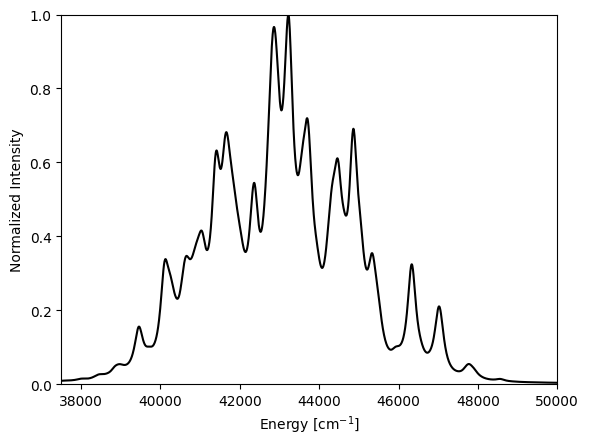

In [14]:
plt.plot(points,yvals/np.max(yvals),'k')
plt.xlim([37500,50000])
plt.ylim([0,1])
test = np.argmax(fc*np.exp(-energy_initial / (kB * Temp)))
plt.ylabel('Normalized Intensity')
plt.xlabel('Energy [cm$^{-1}$]')